In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display
from PIL import Image

## Load the dataset

In [ ]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [ ]:
# @title Dataset Class
class PatchGanData():
  """
   Creates a tf.dataset for pix2pix Model

   Arguments:
      dataset_name (str): dataset name, the name is icluded in the URL of the dataset

   Returns:
      dataset (tf.data.Dataset): dataset containing (input_image,real_image)
  """
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self,dataset_name):
    self.dataset_name = dataset_name
    # The facade training set consist of 400 images
    self.BUFFER_SIZE = 400
    # The batch size of 1 produced better results for the U-Net
    # in the original pix2pix experiment
    self.BATCH_SIZE = 1
    # Each image is 256x256 in size
    self.IMG_WIDTH = 256
    self.IMG_HEIGHT = 256
    self.PATH = None


  def load_dataset(self,):
    _URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{self.dataset_name}.tar.gz'

    path_to_zip = tf.keras.utils.get_file(
        fname=f"{self.dataset_name}.tar.gz",
        origin=_URL,
        extract=True)

    path_to_zip  = pathlib.Path(path_to_zip)

    self.PATH = path_to_zip.parent/dataset_name
    return self.PATH

  # Loads an image for a given path
  def load_image(self, path):
    ## Reads image from path and decode it to the jpeg format
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)

    ## split the image into mask, real
    w = tf.shape(img)[1]
    w = w // 2
    re_img = img[:,:w,:]
    mask_img = img[:,w:,:]

    ## convert both images to float32 images
    re_img = tf.cast(re_img, tf.float32)
    mask_img = tf.cast(mask_img, tf.float32)

    return re_img,mask_img


  # Randomly Crop an image to the original size (256,256,3)
  def random_crop(self, input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, self.IMG_HEIGHT, self.IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]


  # Normalizing the images to [-1, 1]
  def normalize(self, input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

  # Resize an image given its height and width
  def resize(self, input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


  @tf.function()
  def random_jitter(self, input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = self.resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = self.random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
      # Random mirroring
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


  def load_image_train(self, image_file):
    input_image, real_image = self.load_image(image_file)
    input_image, real_image = self.random_jitter(input_image, real_image)
    input_image, real_image = self.normalize(input_image, real_image)

    return input_image, real_image


  def load_image_test(self, image_file):
    input_image, real_image = self.load_image(image_file)
    input_image, real_image = self.resize(input_image, real_image,
                                    self.IMG_HEIGHT, self.IMG_WIDTH)
    input_image, real_image = self.normalize(input_image, real_image)

    return input_image, real_image

  def create_dataset(self,partition='train'):
    part = f'{partition}/*.jpg'
    dataset = tf.data.Dataset.list_files(str(self.PATH / part))
    if partition == 'train':
        dataset = dataset.map(self.load_image_train,
                                      num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(self.load_image_test,
                                      num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(self.BUFFER_SIZE)
    dataset = dataset.batch(self.BATCH_SIZE)
    return dataset

In [ ]:
Dataset = PatchGanData(dataset_name)
Dataset.load_dataset()

30168306/30168306 [==============================] - 16s 1us/step


PosixPath('/root/.keras/datasets/facades')

In [ ]:
train_dataset = Dataset.create_dataset()
test_dataset = Dataset.create_dataset(partition='test')
val_dataset  = Dataset.create_dataset(partition='val')

print(f'train_dataset:\n {train_dataset.element_spec}')
print(f'[!] len of train_dataset: {len(train_dataset)}')
print(f'test_dataset:\n {test_dataset.element_spec}')
print(f'[!] len of test_dataset: {len(test_dataset)}')

train_dataset:
 (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))
[!] len of train_dataset: 400
test_dataset:
 (TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))
[!] len of test_dataset: 106


In [ ]:
# @title Dataset Class visualize Method
@PatchGanData.add_method
def visualize(self,rows=2):
  """
   Visualize a random set of images from the train Dataset

   Arguments:
      rows (int): number of rows of the displayed image

   Returns:
      image (Image)
  """
  if rows % 2 !=0:
    print('[!] rows must be an odd number')
    return

  train_paths = self.PATH.rglob('train/*.jpg')
  train_paths = [str(x) for x in train_paths]
  candidates = np.random.choice(train_paths,size=2*rows,replace=False)
  pad = tf.ones(shape=(10,1024,3),dtype=tf.uint8) * 255

  sample_images = [tf.io.read_file(x) for x in candidates]
  sample_images = [tf.io.decode_jpeg(x) for x in sample_images]
  sample_images = [tf.concat([tf.concat(x,axis=1),pad],axis=0) for x in zip(sample_images[::2],sample_images[1::2])]
  sample_images = tf.concat(sample_images,axis=0)
  required_shape = sample_images.shape[0]-pad.shape[0]
  sample_images = sample_images[:required_shape,:,:]

  return Image.fromarray(sample_images.numpy())


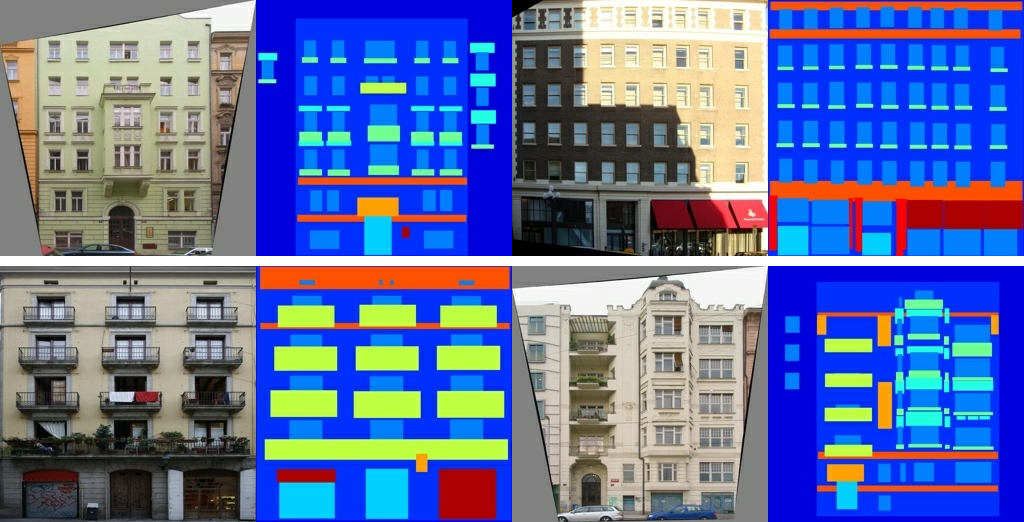

In [ ]:
Dataset.visualize()

## Build the Generator

The generator of your pix2pix cGAN is a modified U-Net
  * Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
  * Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
  * There are skip connections between the encoder and decoder (as in the U-Net).

In [ ]:
class DownSample(tf.keras.layers.Layer):

  def __init__(self,filters, kernel_size=4, batchnorm=True):
    super().__init__()
    self.seq = tf.keras.models.Sequential()
    self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, use_bias=False, padding='same')
    self.seq.add(self.conv)
    if batchnorm:
      self.BatchNorm = tf.keras.layers.BatchNormalization()
      self.seq.add(self.BatchNorm)
    self.activation = tf.keras.layers.LeakyReLU()
    self.seq.add(self.activation)

  def call(self,x):
    return self.seq(x)


In [ ]:
## Test Class
for img,mask in train_dataset.take(1):
  break
downsample = DownSample(3)
downsample(mask).shape

TensorShape([1, 128, 128, 3])

Define the encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  """
   encoder part of the UNET architecture

  """
  def __init__(self, size=64):
    super().__init__()
    self.downsampling = []
    self.stacks = []

    self.downsampling.append(DownSample(size,batchnorm=False))   # (batch_size,128,128,64)
    self.downsampling.append(DownSample(size*2))                # (batch_size,64,64,128)
    self.downsampling.append(DownSample(size*4))                # (batch_size,32,32,256)

    self.downsampling += [DownSample(size*8) for i in range(5)]    # (batch_size,1,1,512)


  def call(self, x):
    for downsample in self.downsampling:
      x = downsample(x)
      self.stacks.append(x)

    return x,self.stacks

In [ ]:
encoder = Encoder()
encoding,stacks = encoder(mask)
for stack in stacks:
  print(stack.shape)
print(encoding.shape)

(1, 128, 128, 64)
(1, 64, 64, 128)
(1, 32, 32, 256)
(1, 16, 16, 512)
(1, 8, 8, 512)
(1, 4, 4, 512)
(1, 2, 2, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)


Define the upsample

In [ ]:
class UpSample(tf.keras.layers.Layer):
  """
   upsample an image
  """
  def __init__(self,filters,size=4,dropout=False):
    super().__init__()
    self.seq = tf.keras.models.Sequential()
    self.deconv = tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    use_bias=False)
    self.seq.add(self.deconv)

    if dropout:
      self.dropout = tf.keras.layers.Dropout(0.5)
      self.seq.add(self.dropout)

    self.activation = tf.keras.layers.ReLU()
    self.seq.add(self.activation)

  def call(self,x):
    return self.seq(x)

In [ ]:
upsample = UpSample(3)
res = upsample(encoding)
res.shape

TensorShape([1, 2, 2, 3])

In [ ]:
class Decoder(tf.keras.layers.Layer):
  """
   Decoder part of the UNET architecture

  """

  def __init__(self,size=512):
    super().__init__()
    self.upsampling = []

    self.upsampling.append(UpSample(size,dropout=True))   # (batch_size,2,2,512)
    self.upsampling.append(UpSample(size,dropout=True))  # (batch_size,4,4,512)
    self.upsampling.append(UpSample(size,dropout=True))  # (batch_size,8,8,512)
    self.upsampling.append(UpSample(size))                # (batch_size,16,16,512)
    self.upsampling += [UpSample(size//(2**i)) for i in range(1,4)]     # ((batch_size,128,128,64))

    self.last = tf.keras.layers.Conv2DTranspose(3,4,
                                                strides=2,
                                                padding='same',
                                                activation='tanh'
                                                )

  def call(self, x):
    skips = reversed(x[:-1])
    x = x[-1]

    for up,skip in zip(self.upsampling,skips):
      x = up(x)
      x = tf.keras.layers.Concatenate()([x,skip])
      # print(x.shape)

    x = self.last(x)

    return x


In [ ]:
decoder = Decoder()
res = decoder(stacks)
res.shape

TensorShape([1, 256, 256, 3])

Build the Generator

In [ ]:
class Generator(tf.keras.Model):
  """
    generate a real image given a mask image
  """
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self,):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def call(self,x):
    """
      Arguments:
          x (tf.Tensor): mask image of shape (1,256,256,3)

      Returns:
          img (tf.Tensor): real image of shape (1,256,256,3)
    """
    encoding,stacks = self.encoder(x)
    img = self.decoder(stacks)
    return img

              mask                            gen


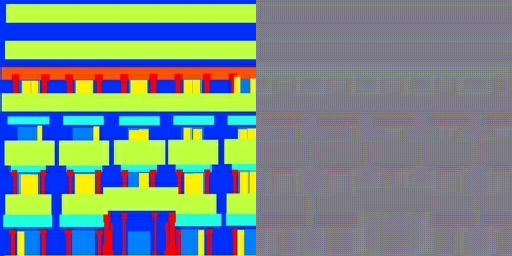

In [ ]:
gen = Generator()
fake_image = gen(mask)

m = (mask + 1)*127.5
f = (fake_image+1)*127.5

space = ''.join([' ' for _ in range(13)])
print(f'{space} mask {2*space} gen')
Image.fromarray(tf.concat([tf.squeeze(m).numpy().astype(np.uint8),tf.squeeze(f).numpy().astype(np.uint8)],axis=1).numpy())

## Build the Discriminator

The discriminator in the pix2pix GAN is a convolutional PatchGAN classifier—it tries to classify if each image patch is real or not real, as described in the pix2pix paper.

  * Each block in the discriminator is: Convolution -> Batch normalization
    -> Leaky ReLU.
  * The shape of the output after the last layer is (batch_size, 30, 30, 1).
  * Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.

  * The discriminator receives 2 inputs:
    * The input image and the target image, which it should classify as real.
    * The input image and the generated image (the output of the generator), which it should classify as fake.
    * Use tf.concat([inp, tar], axis=-1) to concatenate these 2 inputs together.

In [ ]:
class Discriminator(tf.keras.Model):
  """
   Classifies each Patch of image as Real or Fake

  """
  def __init__(self,size=64):
    super().__init__()
    self.concat = tf.keras.layers.Concatenate()

    self.down1 = DownSample(size,batchnorm=False)
    self.down2 = DownSample(size*2)
    self.down3 = DownSample(size*4)

    self.zero_pad1 = tf.keras.layers.ZeroPadding2D()

    self.conv = tf.keras.layers.Conv2D(512,4,
                                       strides = 1,
                                       use_bias=False
                                       )

    self.batchnorm = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.LeakyReLU()
    self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
    self.last = tf.keras.layers.Conv2D(1,4,strides=1)

    self.seq = tf.keras.Sequential([
        self.down1,
        self.down2,
        self.down3,
        self.zero_pad1,
        self.conv,
        self.batchnorm,
        self.activation,
        self.zero_pad2,
        self.last
    ])

  def call(self,inp,tar):
    """
     Argumenst:
        inp (tf.Tensor): mask image of shape (1,256,256,3)
        tar (tf.Tensor): generated image of shape (1,256,256,3)

     Returns:
        patch (tf.Tensor): a tensor of shape (1,30,30,1) , each pixel classidfies a patch of 70*70 from the tar image
    """
    x = self.concat([inp,tar])
    patch = self.seq(x)
    return patch

In [ ]:
disc = Discriminator()
res = disc(mask,fake_image)
res.shape

TensorShape([1, 30, 30, 1])

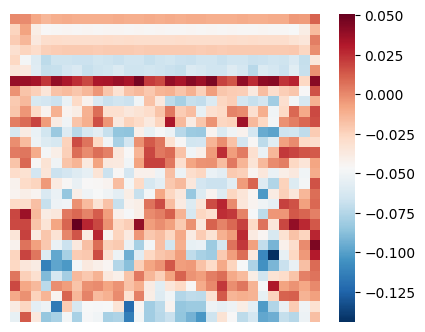

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(res[0,:,:,0], cmap='RdBu_r',xticklabels=False,yticklabels=False)
plt.show()

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.

  * The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
  * The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss is gan_loss + LAMBDA  l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(disc_generated_output, gen_output, target):
  """
   Calculates the Generator loss

   Arguments:
      disc_generated_output (tf.Tensor): the output of the discriminator of shape (1,30,30,1)
      gen_output (tf.Tensor): generated image of the Gnerator of shape (1,256,256,3)
      target (tf.Tensor): real image of shape (1,256,256,3)

   Returns:
      Total_Gnerator_loss , GAN_loss , L1_loss
  """
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
generator_loss(res,fake_image,img)

(<tf.Tensor: shape=(), dtype=float32, numpy=33.913265>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6932518>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.33220014>)

### Define the discriminator loss


The discriminator_loss function takes 2 inputs: real images and generated images.
  * real_loss is a sigmoid cross-entropy loss of the real images and an array of ones(since these are the real images).
  * generated_loss is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
  * The total_loss is the sum of real_loss and generated_loss.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  """
   Calculates the Discriminator loss

   Arguments:
      disc_real_output (tf.Tensor): the discriminator output given the real image as input and the real image as target
      disc_generated_output (tf.Tensor): the discriminator output given the fake image as input and the real image as target
  """
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
disc_real_output = disc(mask,img)
disc_generated_output = disc(mask,fake_image)
discriminator_loss(disc_real_output, disc_generated_output)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3808607>

## Generate images

In [ ]:
@Generator.add_method
def generate(self,inp,tar=None,training=True):
  plt.figure(figsize=(12,12))
  fake = self(inp,training=training)

  if tar is not None:
    display_list = [inp[0], tar[0], fake[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

  else:
    display_list = [inp[0],fake[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

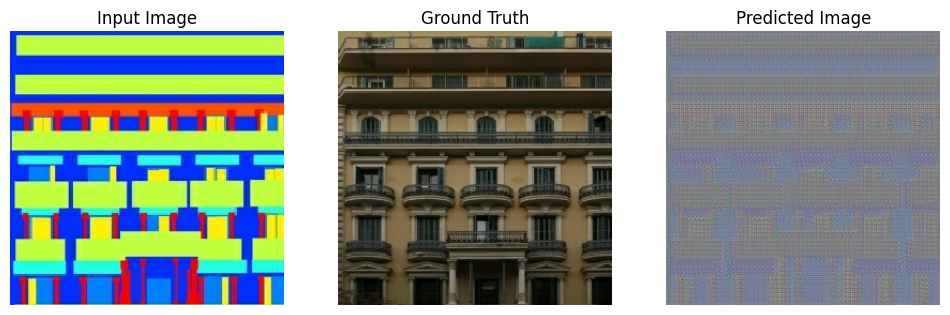

In [ ]:
gen.generate(mask,tar=img)

## Train Model

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
gen = Generator()
disc = Discriminator()

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(log_dir)

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = gen(input_image, training=True) # fake image of shape (1,256,256,3)

    disc_real_output = disc(input_image, target, training=True)  # disc(mask,real)
    disc_generated_output = disc(input_image, gen_output, training=True)  # disc(mask,fake)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


  ## Gradients
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          gen.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               disc.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          gen.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              disc.trainable_variables))


  # Log to TensorBoard
  with summary_writer.as_default():
      step = step // 1000
      tf.summary.scalar('Generator Total Loss', gen_total_loss, step=step)
      tf.summary.scalar('Generator GAN Loss', gen_gan_loss, step=step)
      tf.summary.scalar('Generator L1 Loss', gen_l1_loss, step=step)
      tf.summary.scalar('Discriminator Loss', disc_loss, step=step)

In [ ]:
def fit(train_ds, test_ds, steps=40000):
  example_target, example_input = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (target, input_image) in train_ds.repeat().take(steps).enumerate():

    #####################################
    ## Visualisation
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      gen.generate(example_input, tar=example_target)
      print(f"Step: {step//1000}k")
    #######################################

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


Time taken for 1000 steps: 92.79 sec



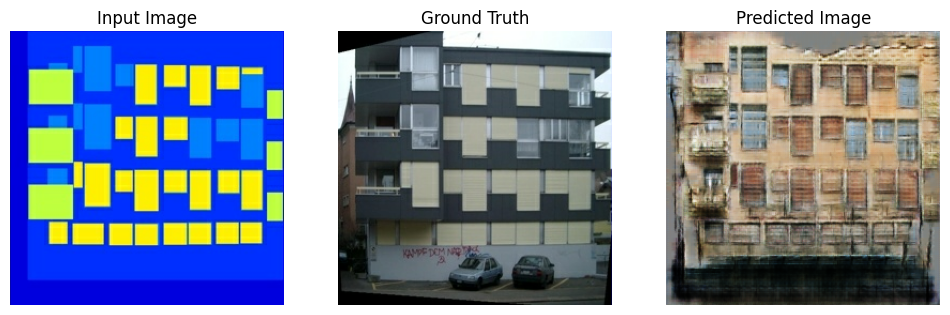

Step: 38k
.......

In [ ]:
fit(train_dataset,test_dataset,steps=40000)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
for img,mask in train_dataset.take(2):
  gen.generate(mask,tar=img)

## Generate some images using the test set

In [ ]:
for img,mask in test_dataset.take(5):
  gen.generate(mask,tar=img)